In [1]:
# STEP 1: ACCEPT AUDIO INPUT
import os
import IPython.display as ipd

muffled_file = 'muffled-talking-6161.mp3' # source url: https://pixabay.com/sound-effects/search/muffled-talking/
sample_rate = 44100 # default sample rate for audio processing is 44.1 Hz

ipd.Audio(muffled_file, rate=sample_rate)

In [2]:
%pip install librosa

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


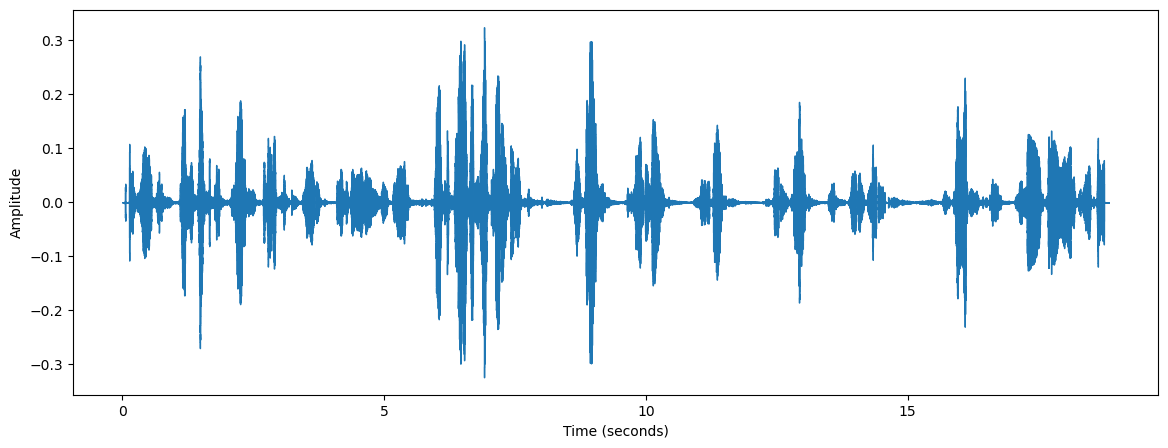

In [3]:
# STEP 2: DISPLAY AUDIO AS A SIGNAL
import librosa # package for music & audio analysis
import numpy
from pylab import plot, figure, show, xlabel, ylabel

# PART A: WORKING WITH INPUT AUDIO
muffled_c4, m_sr = librosa.load(muffled_file)

# plot the signal's waveform
figure(figsize=(14, 5))
librosa.display.waveshow(muffled_c4, sr=m_sr)
xlabel('Time (seconds)')
ylabel('Amplitude')
show()

In [4]:
# PART B: TRYING SIMPLE MODIFICATIONS -> THEY AREN'T GOOD ENOUGH

# amplitude multiplier
amp_factor = 100
amp_signal = muffled_c4 * amp_factor
ipd.Audio(amp_signal, rate=m_sr)

In [5]:
# slowing down audio
stretch_signal = librosa.effects.time_stretch(muffled_c4, rate=0.85)
resampled_stretch_signal = librosa.resample(stretch_signal, orig_sr=len(stretch_signal), target_sr=len(muffled_c4))
ipd.Audio(stretch_signal, rate=m_sr)

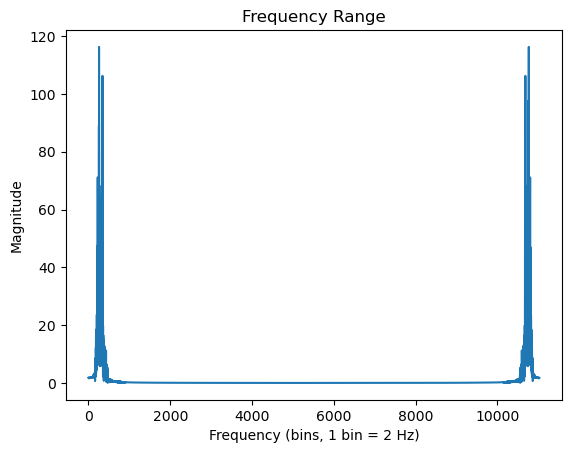

In [6]:
# STEP 3: EXTRACT FREQUENCIES VIA FOURIER TRANSFORM
from numpy import zeros
from cmath import exp, pi
from pylab import title

# define discrete fourier transform
def dft(y):
    N = len(y)
    c = zeros(N, complex)
    for k in range(N):
        for n in range(N):
            c[k] += y[n]*exp(-2j*pi*k*n/N)
    return c

# decide a subset for the transform -> where there is the most audio modulation
startIdx = 6 * 22050 # find the sample # at 6s mark
endIdx = 11025 + startIdx # find the sample # at 6.5s mark

# plot transform of signal
transform = dft(muffled_c4[startIdx:endIdx])
plot(abs(transform))
xlabel('Frequency (bins, 1 bin = 2 Hz)')
ylabel('Magnitude')
title('Frequency Range')
show()


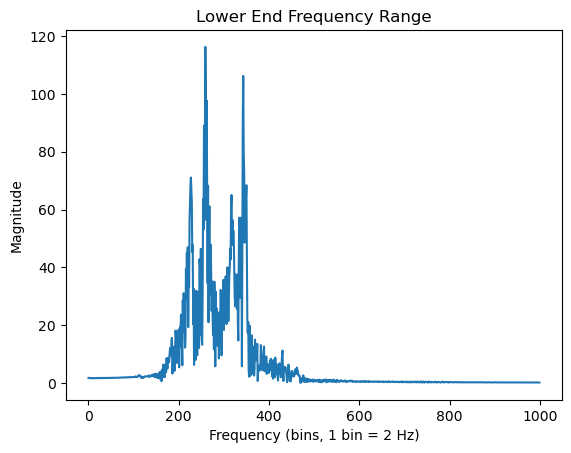

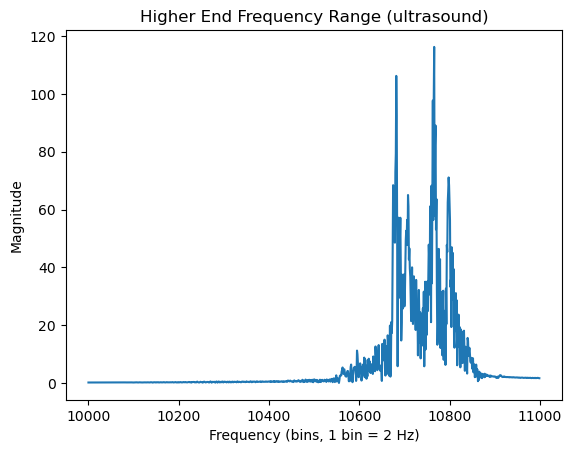

In [7]:
# zoom into interesting sections of the plot i.e. sections with the most change in value

# lower end frequency range
lowerend_transform = abs(transform[0:1000])
plot(lowerend_transform)
xlabel('Frequency (bins, 1 bin = 2 Hz)')
ylabel('Magnitude')
title('Lower End Frequency Range')
show()

# higher end frequency range
from numpy import arange

higherend_transform = abs(transform[10000:11000])
plot(10000 + arange(1000), higherend_transform)
xlabel('Frequency (bins, 1 bin = 2 Hz)')
ylabel('Magnitude')
title('Higher End Frequency Range (ultrasound)')
show()

In [13]:
# STEP 4: DEVISE METHODS TO SELECTIVELY AMPLIFY COMPLEX SOUNDS
from numpy import sqrt

# PART A: FREQUENCY ANALYSIS VIA GOLDEN RATIO SEARCH FOR LOCAL & GLOBAL MAXIMA

# local maxima in an audio signal are all harmonic frequencies
def find_harmonics(signal, tolerance):
    golden_ratio = (sqrt(5) - 1) / 2
    
    a = 0
    b = len(signal) - 1
    
    freq_maxima = []
    
    while abs(b - a) > tolerance:
        c = b - (b - a) * golden_ratio
        d = a + (b - a) * golden_ratio
        
        fc = signal[int(c)]
        fd = signal[int(d)]
        
        if fc < fd:
            a = c
            freq_maxima.append(int(c))
        else:
            b = d
            freq_maxima.append(int(d))
        
    return freq_maxima

# the global maximum is the most common frequency, which is the fundamental frequency of an audio signal
def find_fundamental(signal, local_maxima):
    max_val = 0
    max_freq = 0
    
    for m in local_maxima:
        if signal[m] > max_val:
            max_val = signal[m]
            max_freq = m
    
    return max_freq

# test on lower end frequency range
lowerend_harmonics = find_harmonics(lowerend_transform, 1e-05)
lowerend_fundamental = find_fundamental(lowerend_transform, lowerend_harmonics) * 2 # scale bins to Hz

print('Fundamental Frequency: ', lowerend_fundamental, ' Hz')
print(lowerend_transform[259])
print(lowerend_transform[260])
print(lowerend_transform[258])

print('Harmonics: ')
for h in lowerend_harmonics:
    print(h * 2, ' Hz')

Fundamental Frequency:  518  Hz
116.22455061032198
97.98088651687793
57.85533431339062
Harmonics: 
1234  Hz
762  Hz
290  Hz
582  Hz
402  Hz
470  Hz
540  Hz
496  Hz
514  Hz
530  Hz
524  Hz
520  Hz
516  Hz
518  Hz
516  Hz
518  Hz
516  Hz
518  Hz
516  Hz
518  Hz
516  Hz
518  Hz
518  Hz
518  Hz
518  Hz
518  Hz
518  Hz
516  Hz
518  Hz
516  Hz
518  Hz
518  Hz
518  Hz
516  Hz
518  Hz
516  Hz
518  Hz
518  Hz
518  Hz


In [14]:
# PART B: FREQUENCY TRIMMING

# remove unnecessary frequencies
def freq_trimmer(signal, harmonics, limit):
    N = len(signal)
    c = zeros(N, complex)
    
    for n in range(N):
        if n in harmonics:
            continue
        if signal[n] < limit:
            c[n] = 0
        else:
            c[n] = signal[n]
    
    return c.real

In [15]:
# PART C: PITCH SHIFTING VIA PHASE MANIPULATION
def pitch_push(signal, freq_shift, sr):
    # compute the phase shift based on the frequency shift
    phase_shift = 2 * pi * freq_shift / sr

    # normalize time axis that helps incorporate shift
    N = len(signal)
    t = arange(N)
    
    # apply phase shift to direct audio signal
    shifted_audio = zeros(N, complex)
    for n in range(N):
        shifted_audio[n] = signal[n] * exp(phase_shift*t[n]/sr)
        
    return shifted_audio.real

In [16]:
# PART D: NOISE REDUCTION BY SPECTRAL SUBTRACTION
from numpy import mean, where, max

def noise_reduce(signal, threshold):
    # calculate power spectrum from fourier transform
    power_spectrum = abs(signal) ** 2

    # apply noise condition to find general noise spectrum from power spectrum -> less specific than high/low/band-pass filter
    noise_spectrum = mean(power_spectrum[where(power_spectrum < threshold * max(power_spectrum))])

    # perform spectral subtraction
    clean_spectrum = power_spectrum - noise_spectrum
    plot(clean_spectrum)
    return clean_spectrum

In [17]:
# STEP 5: PLAYBACK AMPLIFIED AUDIO & COMPARE WITH ORIGINAL

# define inverse discrete fourier transform to convert fourier coefficients back into a signal
def inverse_dft(c):
    N = len(c)
    y = zeros(N, complex)
    for k in range(N):
        for n in range(N):
            y[k] += c[n]*exp(2j*pi*k*n/N)/N
    return y.real

# plot the modified audio signal
def playback_plot(signal):
    # plot the signal's waveform
    plot(signal)
    xlabel('Time (samples)')
    ylabel('Amplitude')
    show()

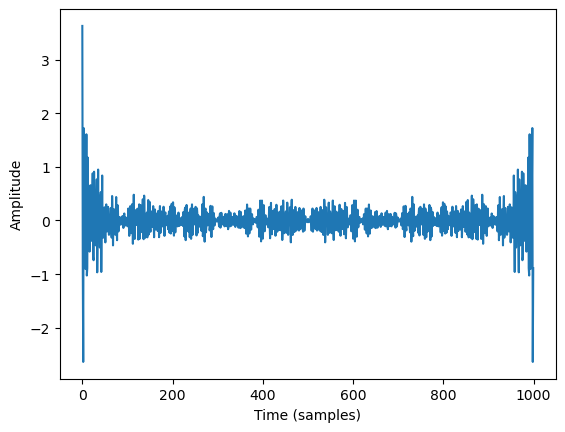

In [18]:
# PART A: TEST FREQUENCY TRIMMING
trimmed_signal = freq_trimmer(lowerend_transform, lowerend_harmonics, 30)

inv = inverse_dft(trimmed_signal)
playback_plot(inv)

ipd.Audio(inv, rate=m_sr)

In [19]:
# PART B: TEST PITCH SHIFTING
pitchpushed_signal = pitch_push(muffled_c4, 400, m_sr)

ipd.Audio(pitchpushed_signal, rate=m_sr)

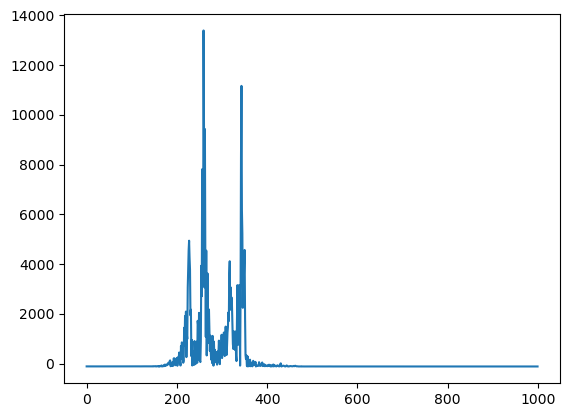

In [20]:
# PART C: TEST NOISE REDUCTION
reduced_signal = noise_reduce(lowerend_transform, 0.18)

inv_r = inverse_dft(reduced_signal)

ipd.Audio(inv_r, rate=m_sr)

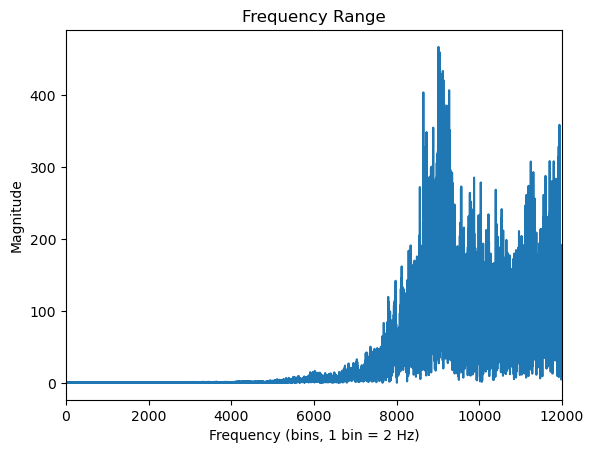

In [21]:
# PART D: COMBINE IT ALL -> LIMITED USE ON LARGE NUMBER OF SAMPLES
from numpy.fft import fft as fast_ft # use in-built fast fourier transform to quickly run on the entire signal
from numpy.fft import ifft as fast_ift # use in-built fast inverse fourier transform to quickly run on the entire signal
from pylab import xlim

fulltr = fast_ft(muffled_c4)
plot(abs(fulltr))
xlim(0, 12000)
xlabel('Frequency (bins, 1 bin = 2 Hz)')
ylabel('Magnitude')
title('Frequency Range')
show()

In [22]:
# PART I: DO FREQUENCY ANALYSIS
full_harmonics = find_harmonics(fulltr, 1e-05)

C:\ProgramData\anaconda3\Lib\site-packages\matplotlib\cbook\__init__.py:1340: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


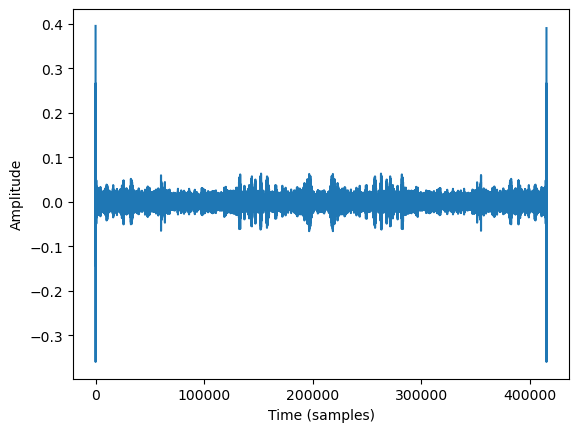

C:\ProgramData\anaconda3\Lib\site-packages\IPython\lib\display.py:172: ComplexWarning: Casting complex values to real discards the imaginary part
  data = np.array(data, dtype=float)


In [23]:
# PART II: DO FREQUENCY TRIMMING
full_trim = freq_trimmer(fulltr, full_harmonics, 100)

inv_ft = fast_ift(full_trim)
playback_plot(inv_ft)

ipd.Audio(inv_ft, rate=m_sr)

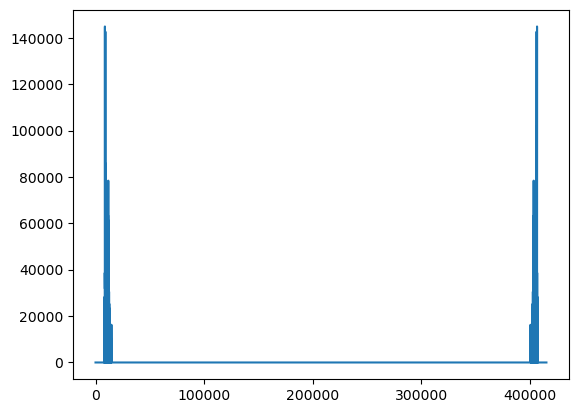

In [24]:
# PART III: DO NOISE REDUCTION ON TRIMMED WAVE
full_reduce = noise_reduce(fast_ft(inv_ft), 1000)

inv_fr = fast_ift(full_reduce)
        
ipd.Audio(inv_fr, rate=m_sr)

In [25]:
# PART IV: DO PITCH SHIFTING ON NOISE REDUCED WAVE
full_pitchpush_nr = pitch_push(inv_fr, 50, m_sr)

ipd.Audio(full_pitchpush_nr, rate=m_sr)